In [1]:
import pandas as pd
import os
import sys

def leer_archivo(ruta_archivo: str):
    # Verificar que el archivo existe
    if not os.path.exists(ruta_archivo):
        sys.exit(f"❌ El archivo no existe: {ruta_archivo}")

    # Detectar la extensión
    extension = os.path.splitext(ruta_archivo)[1].lower()

    try:
        if extension == ".csv":
            df = pd.read_csv(
                ruta_archivo,
                thousands=",",         # ✅ interpreta comas como miles (2022, 20000)
                na_values=["", " "],   # ✅ vacíos como NaN
                keep_default_na=True
            )
        elif extension in [".xls", ".xlsx"]:
            df = pd.read_excel(ruta_archivo)
        elif extension == ".json":
            df = pd.read_json(ruta_archivo)
        else:
            sys.exit(f"⚠️ Tipo de archivo no soportado: {extension}")

        # Mostrar solo las primeras 10 filas
        print(df.head(10))
        return df

    except Exception as e:
        sys.exit(f"❌ Error al leer el archivo: {e}")

In [ ]:
def combinar_dataframes(df1, df2, cols1=None, cols2=None, how="inner"):
    """
    Combina dos DataFrames en base a columnas comunes o especificadas.
    
    Parámetros:
    -----------
    df1 : DataFrame
        Primer DataFrame
    df2 : DataFrame
        Segundo DataFrame
    cols1 : str o list, opcional
        Columna(s) en df1 para la unión
    cols2 : str o list, opcional
        Columna(s) en df2 para la unión
    how : str, default "inner"
        Tipo de unión: 'left', 'right', 'outer', 'inner'

    Retorna:
    --------
    DataFrame combinado
    """
    if cols1 is None and cols2 is None:
        # Detectar columnas comunes automáticamente
        comunes = list(set(df1.columns) & set(df2.columns))
        if not comunes:
            raise ValueError("❌ No hay columnas en común para combinar.")
        return pd.merge(df1, df2, on=comunes, how=how)

    elif cols1 is not None and cols2 is not None:
        # Unión con columnas diferentes
        return pd.merge(df1, df2, left_on=cols1, right_on=cols2, how=how)

    else:
        raise ValueError("❌ Debes pasar ambas listas de columnas (cols1 y cols2) o ninguna.")

In [3]:
import matplotlib.pyplot as plt

# Ruta del archivo
ruta = "./data/num_ev.csv"
df = leer_archivo(ruta)

  COMBUSTIBLE  ESTADO  MODELO           FECHA_REGISTRO  AÑO_REGISTRO  \
0   ELECTRICO  ACTIVO    2022  2022 Jun 30 12:00:00 AM          2022   
1   ELECTRICO  ACTIVO    2023  2022 Oct 21 12:00:00 AM          2022   
2   ELECTRICO  ACTIVO    2014  2015 Sep 28 12:00:00 AM          2015   
3   ELECTRICO  ACTIVO    2021  2022 Aug 10 12:00:00 AM          2022   
4   ELECTRICO  ACTIVO    2022  2021 Oct 25 12:00:00 AM          2021   
5   ELECTRICO  ACTIVO    2023  2022 Aug 03 12:00:00 AM          2022   
6   ELECTRICO  ACTIVO    2020  2019 Oct 31 12:00:00 AM          2019   
7   ELECTRICO  ACTIVO    2022  2021 Aug 27 12:00:00 AM          2021   
8   ELECTRICO  ACTIVO    2023  2022 Sep 14 12:00:00 AM          2022   
9   ELECTRICO  ACTIVO    2020  2020 Jun 10 12:00:00 AM          2020   

  CLASIFICACION        CLASE    SERVICIO     MARCA            LINEA  ...  \
0     AUTOMOVIL          BUS     Público       BYD          BC11S01  ...   
1     AUTOMOVIL    CAMIONETA  Particular       BYD     

In [4]:
# ---------------------------
# Limpieza de columnas numéricas
# ---------------------------
# Asegurar que algunas columnas sean numéricas
cols_numericas = ["AÑO_REGISTRO", "CAPACIDAD_PASAJEROS", "POTENCIA"]
for col in cols_numericas:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

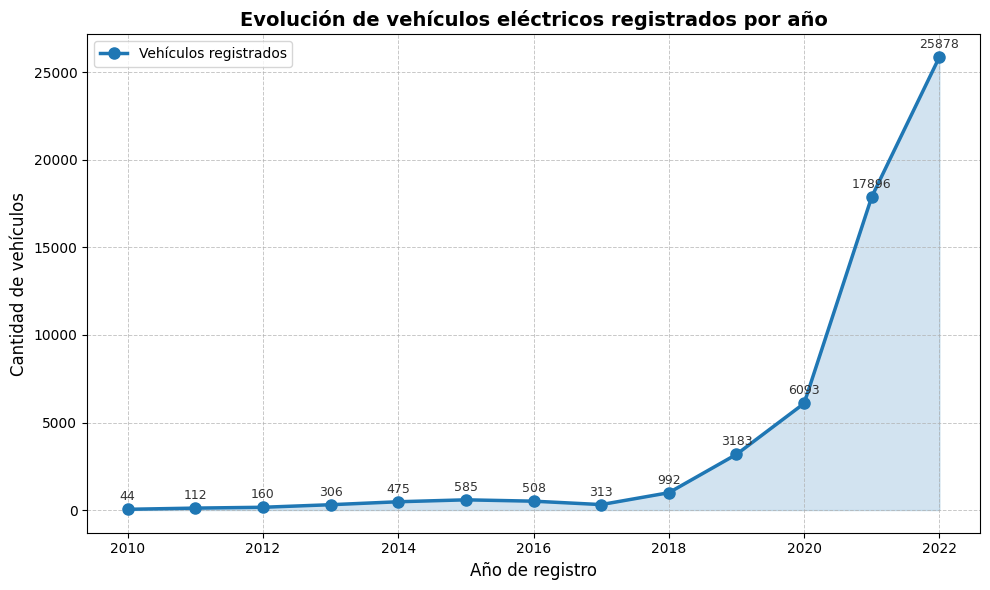

In [5]:
# ---------------------------
# 1. Vehículos registrados por año
# ---------------------------

conteo_anual = df["AÑO_REGISTRO"].value_counts().sort_index()

plt.figure(figsize=(10, 6))

# Línea con puntos destacados
plt.plot(
    conteo_anual.index, conteo_anual.values,
    marker="o", markersize=8,
    color="#1f77b4", linewidth=2.5,
    label="Vehículos registrados"
)

# Relleno suave bajo la curva
plt.fill_between(
    conteo_anual.index, conteo_anual.values,
    color="#1f77b4", alpha=0.2
)

# Título y ejes más descriptivos
plt.title("Evolución de vehículos eléctricos registrados por año", fontsize=14, fontweight="bold")
plt.xlabel("Año de registro", fontsize=12)
plt.ylabel("Cantidad de vehículos", fontsize=12)

# Líneas de cuadrícula suaves
plt.grid(True, which="both", linestyle="--", linewidth=0.7, alpha=0.7)

# Mostrar los valores encima de los puntos
for x, y in zip(conteo_anual.index, conteo_anual.values):
    plt.text(x, y + (max(conteo_anual.values) * 0.02), str(y),
            ha="center", fontsize=9, color="#333")

# Leyenda
plt.legend()

plt.tight_layout()
plt.show()

/tmp/ipykernel_3919/1157066623.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


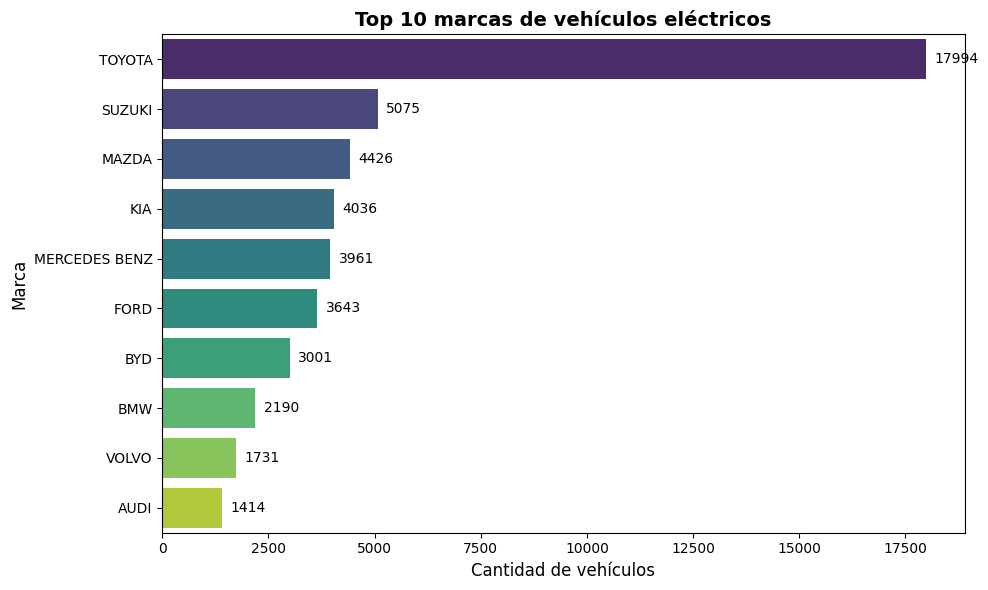

In [6]:
# ---------------------------
# 2. Distribución por marca (Top 10)
# ---------------------------
import seaborn as sns

# Top 10 marcas
top_marcas = df["MARCA"].value_counts().head(10)

plt.figure(figsize=(10, 6))

# Gráfico de barras horizontal con colores bonitos
sns.barplot(
    x=top_marcas.values,
    y=top_marcas.index,
    palette="viridis"
)

# Título y etiquetas
plt.title("Top 10 marcas de vehículos eléctricos", fontsize=14, fontweight="bold")
plt.xlabel("Cantidad de vehículos", fontsize=12)
plt.ylabel("Marca", fontsize=12)

# Etiquetas de valor al final de cada barra
for i, v in enumerate(top_marcas.values):
    plt.text(v + 200, i, str(v), va="center", fontsize=10, color="black")

plt.tight_layout()
plt.show()

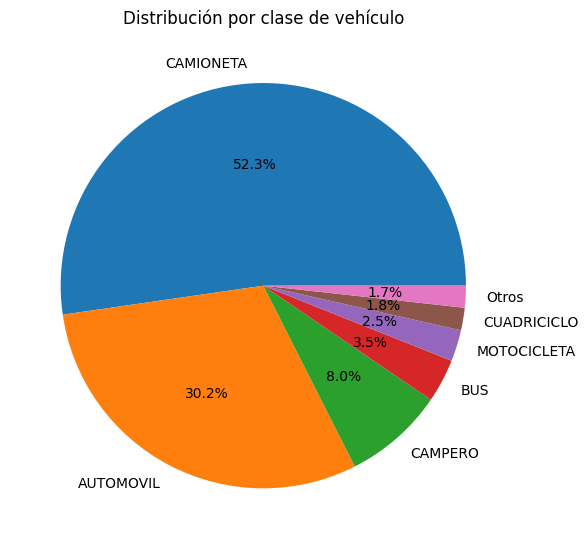

In [7]:
# ---------------------------
# 3. Clasificación por clase (Automóvil, Moto, Bus…)
# ---------------------------
# import matplotlib.pyplot as plt

# Calculamos la distribución de clases
class_counts = df["CLASE"].value_counts()

# Encontramos las clases con menos del 1%
threshold = class_counts.sum() * 0.01
small_classes = class_counts[class_counts < threshold].index

# Agrupamos esas clases en "Otros"
df["CLASE"] = df["CLASE"].replace(small_classes, "Otros")

# Recalculamos la distribución con el nuevo grupo "Otros"
class_counts = df["CLASE"].value_counts()

# Graficamos el nuevo pie chart
plt.figure(figsize=(6, 6))
class_counts.plot(kind="pie", autopct='%1.1f%%')
plt.title("Distribución por clase de vehículo")
plt.ylabel("")  # Quitar etiqueta lateral
plt.tight_layout()
plt.show()


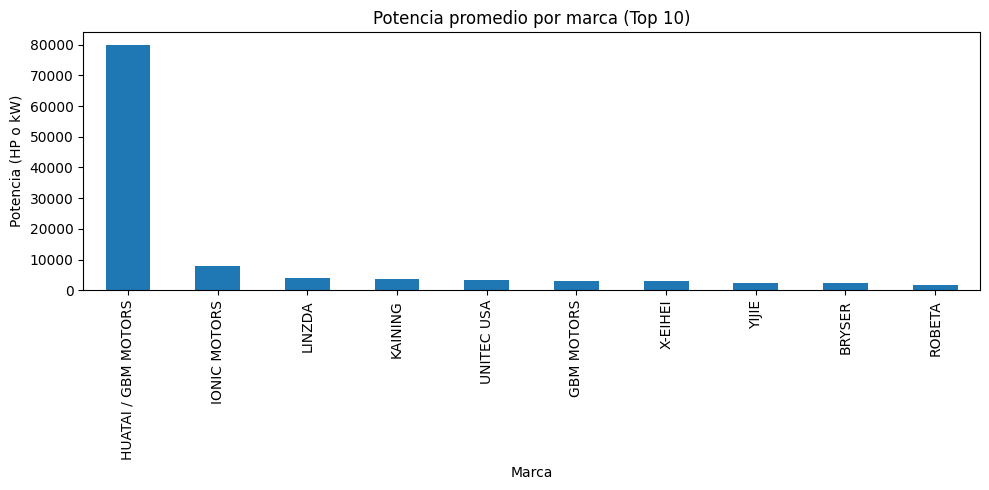

In [8]:
# ---------------------------
# 4. Potencia promedio por marca (Top 10)
# ---------------------------
if "POTENCIA" in df.columns:
    potencia_marca = df.groupby("MARCA")["POTENCIA"].mean().sort_values(ascending=False).head(10)
    plt.figure(figsize=(10, 5))
    potencia_marca.plot(kind="bar")
    plt.title("Potencia promedio por marca (Top 10)")
    plt.xlabel("Marca")
    plt.ylabel("Potencia (HP o kW)")
    plt.tight_layout()
    plt.show()

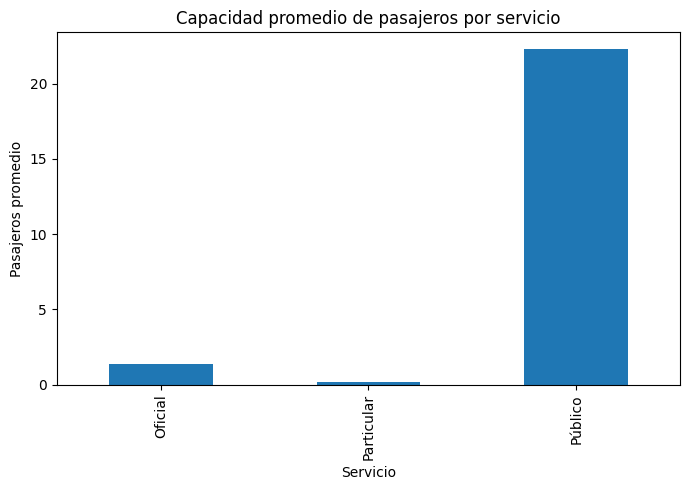

In [9]:
# ---------------------------
# 5. Capacidad de pasajeros por tipo de servicio
# ---------------------------
if "CAPACIDAD_PASAJEROS" in df.columns and "SERVICIO" in df.columns:
    plt.figure(figsize=(7, 5))
    df.groupby("SERVICIO")["CAPACIDAD_PASAJEROS"].mean().plot(kind="bar")
    plt.title("Capacidad promedio de pasajeros por servicio")
    plt.xlabel("Servicio")
    plt.ylabel("Pasajeros promedio")
    plt.tight_layout()
    plt.show()

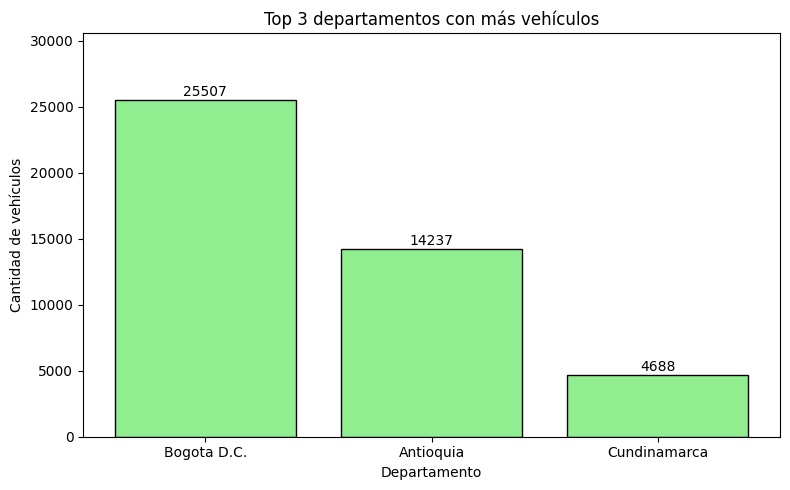

In [10]:
# Contar vehículos por departamento
departamento_counts = df["DEPARTAMENTO"].value_counts()

# Separar top 3 y el resto
top3 = departamento_counts.head(3)

# Gráfico del Top 3
plt.figure(figsize=(8, 5))
bars_top3 = plt.bar(top3.index, top3.values, color="lightgreen", edgecolor="black")
plt.title("Top 3 departamentos con más vehículos")
plt.xlabel("Departamento")
plt.ylabel("Cantidad de vehículos")
# plt.xticks(rotation=45)
plt.ylim(0, max(top3.values) * 1.2)  # Para top3
for bar in bars_top3:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 100, f'{height}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

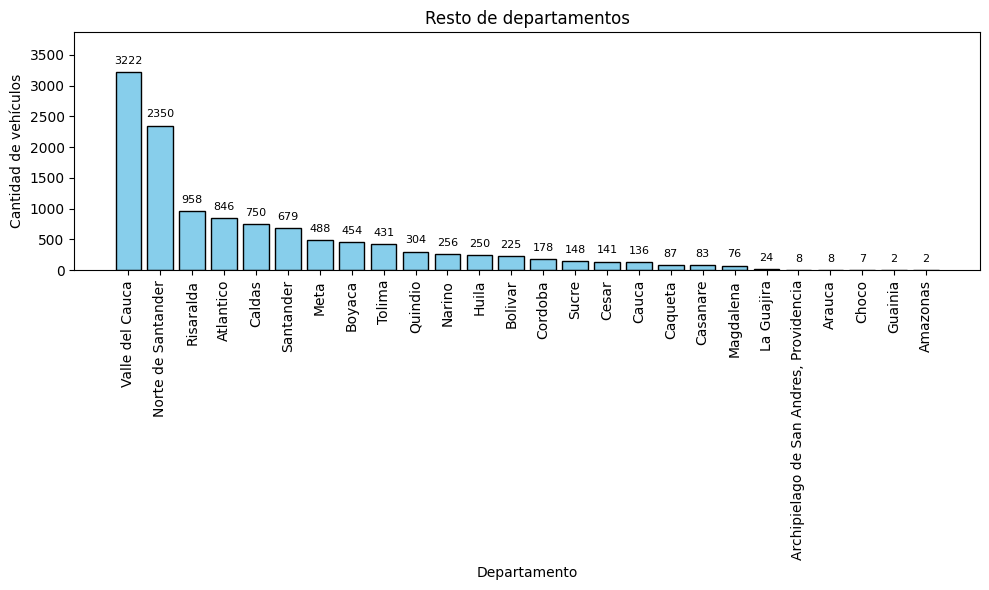

In [11]:
resto = departamento_counts.iloc[3:]

# Gráfico del resto
plt.figure(figsize=(10, 6))
bars_resto = plt.bar(resto.index, resto.values, color="skyblue", edgecolor="black")
plt.title("Resto de departamentos")
plt.xlabel("Departamento")
plt.ylabel("Cantidad de vehículos")
plt.xticks(rotation=90)
plt.ylim(0, max(resto.values) * 1.2)  # Para resto
for bar in bars_resto:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 100, f'{height}', ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()